In [43]:
#Import bundle sampling and analysis functions
from dreimac import CircularCoords
import circle_bundles as cb
import synthetic as sy

cb.attach_bundle_viz_methods()

from circle_bundles import RP2UnitVectorMetric as rp2_metric

import matplotlib.pyplot as plt


# Generate Or Load A Dataset

## Generate From A Template 

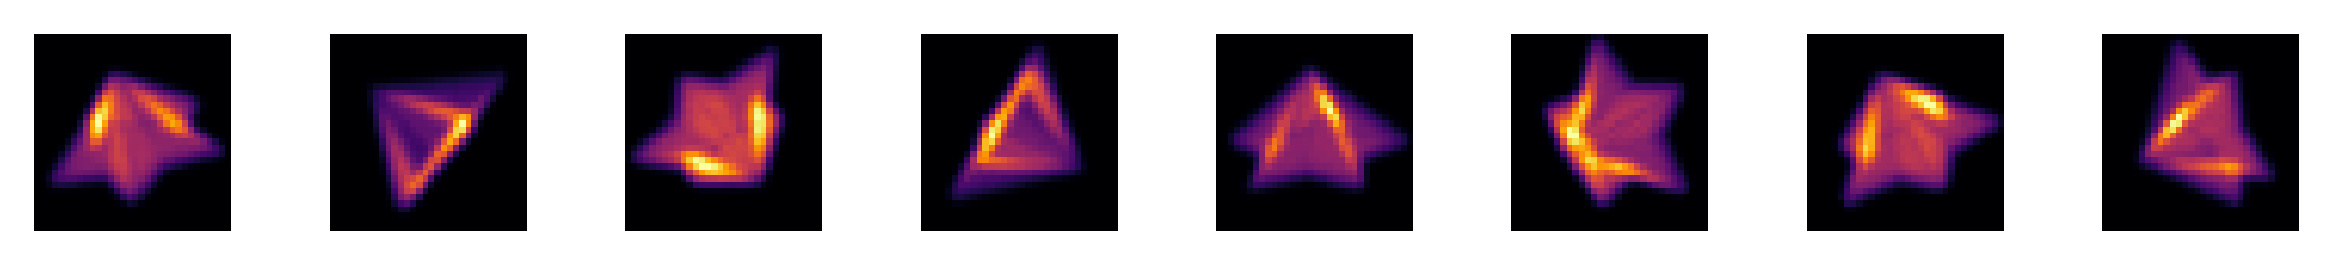

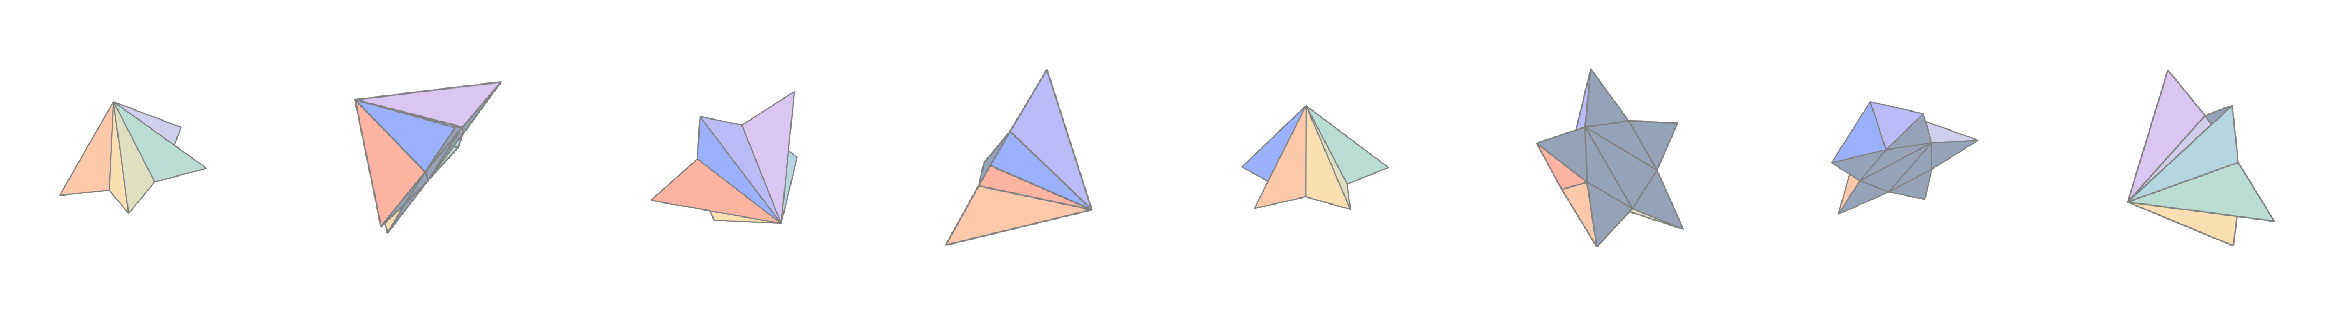

In [2]:
#Get a density
p = 5
height = 1
grid_size = 32

mesh = sy.make_star_pyramid(n_points = p, height = height)
density = sy.mesh_to_density(mesh, grid_size=grid_size, sigma=0.05)

vis_func = sy.make_density_visualizer(grid_size = grid_size)
mesh_vis = sy.make_star_pyramid_visualizer(mesh)

#View a visualization of the mesh
#SO3_data = np.array([np.eye(3).flatten()])  #View the template
n_samples = 8
SO3_data = sy.sample_SO3(n_samples)[0]

density_sample = sy.rotate_density(density, SO3_data, grid_size = grid_size)
fig = cb.show_data_vis(density_sample, 
                       vis_func, 
                       max_samples = n_samples, 
                       n_cols = n_samples, 
                       sampling_method = 'first')
plt.show()

mesh_sample = sy.get_mesh_sample(mesh, SO3_data)

fig = cb.show_data_vis(mesh_sample, 
                       mesh_vis, 
                       max_samples = n_samples, 
                       n_cols = n_samples, 
                       pad_frac = 0.3, 
                       sampling_method = 'first')
plt.show()


In [3]:
#About 60 seconds

#Generate a dataset of random rotations
n_samples = 5000
SO3_data = sy.sample_SO3(n_samples)[0]

data = sy.rotate_density(density, SO3_data, grid_size = grid_size)

#Create the corresponding triangle meshes for visualization
mesh_data = sy.get_mesh_sample(mesh, SO3_data)

print(f'{n_samples} triangle meshes and 3D densities generated.')

5000 triangle meshes and 3D densities generated.


## Load A Dataset

In [ ]:
import pickle

save_path = '/Users/bradturow/Desktop/Circle Bundle Code/star_pyramid_data.pkl'
with open(save_path, 'rb') as f:
    data_dict = pickle.load(f)

n_samples = 5000  

data = data_dict['density data'][:n_samples]
mesh_data = data_dict['mesh data'][:n_samples]
base_points = data_dict['rp2 projections'][:n_samples]

#For visualization
grid_size = data_dict['density grid size']
mesh = data_dict['trimesh object']
vis_func = sy.make_density_visualizer(grid_size = grid_size)
mesh_vis = sy.make_star_pyramid_visualizer(mesh)

print(f'Loaded {n_samples} rotated prisms and corresponding 3D densities.')

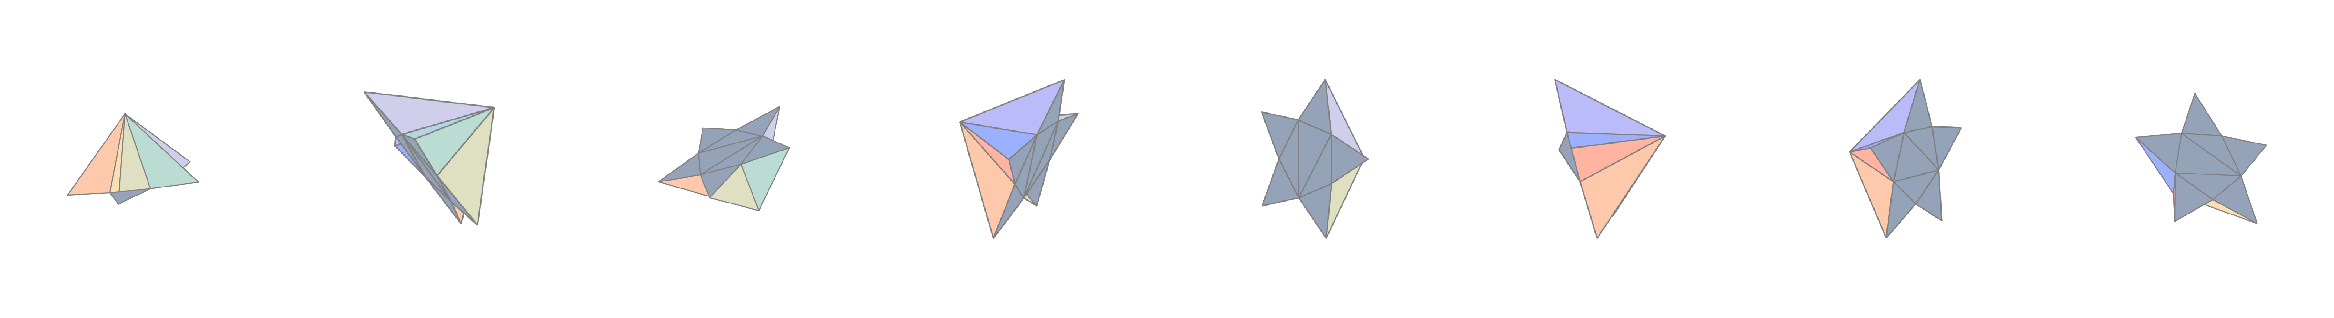

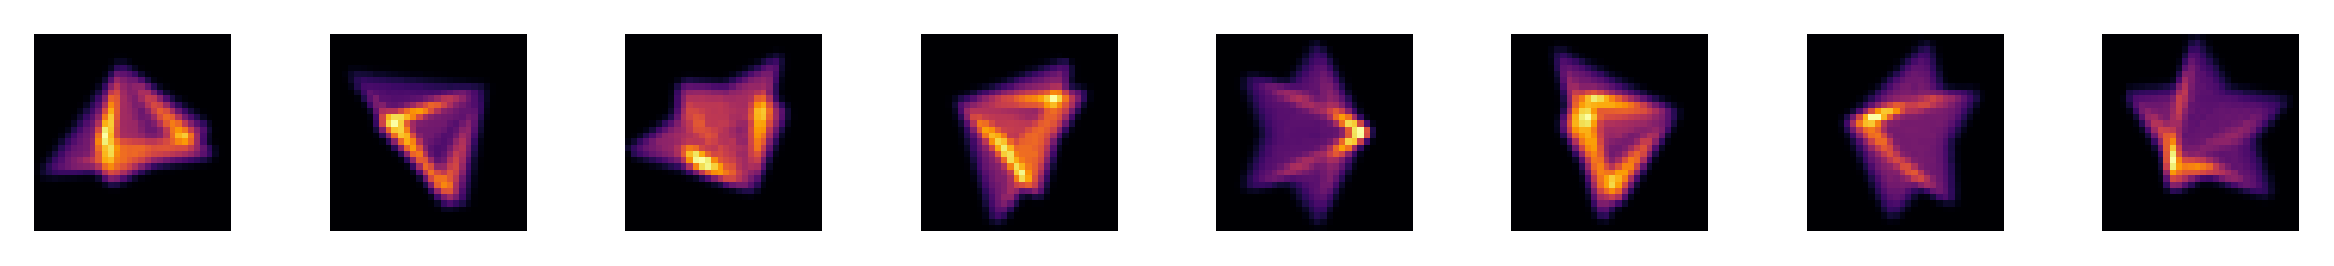

In [4]:
#Show some samples
n_samples = 8
save_path = None

inds = np.random.choice(len(data), n_samples)
fig = cb.show_data_vis(mesh_data[inds], mesh_vis, max_samples = n_samples, n_cols = n_samples, save_path = save_path, sampling_method = 'first', pad_frac = 0.4)
plt.show()

fig = cb.show_data_vis(data[inds], vis_func, max_samples = n_samples, n_cols = n_samples, save_path = save_path, sampling_method = 'first')
plt.show()



# Preliminary Analysis

In [5]:
#Compute base projections
base_points = sy.get_density_axes(data)
print('Base projections computed.')

Base projections computed.


In [ ]:
#Show a PCA visualization of the dataset
cb.show_pca(data, max_points = 500)

In [ ]:
#Show an interactive visualization of the projection mapping
app = cb.show_bundle_vis(base_points = base_points, 
                         data  = data, 
                         base_metric = rp2_metric(), max_samples = 5000)


In [ ]:
#Run Ripser on a sample of the data
from ripser import ripser
from persim import plot_diagrams


# Run Ripser
dgms_2 = ripser(data, coeff=2, maxdim=2, n_perm=500)["dgms"]
dgms_3 = ripser(data, coeff=3, maxdim=2, n_perm=500)["dgms"]

# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

plot_diagrams(dgms_2, ax=axes[0], title="coeff = 2")
plot_diagrams(dgms_3, ax=axes[1], title="coeff = 3")

plt.tight_layout()
plt.show()


# Bundle Analysis

## Base Projections And Cover 

### Cover And Nerve Summary
- $n_\text{sets} = 40$, $n_\text{samples} = 5000$

**Recorded Simplex Counts:**

- $\#(\text{0-simplices}) = 40$
- $\#(\text{1-simplices}) = 117$
- $\#(\text{2-simplices}) = 78$
- *No recorded simplices in dimensions* $\ge 3$

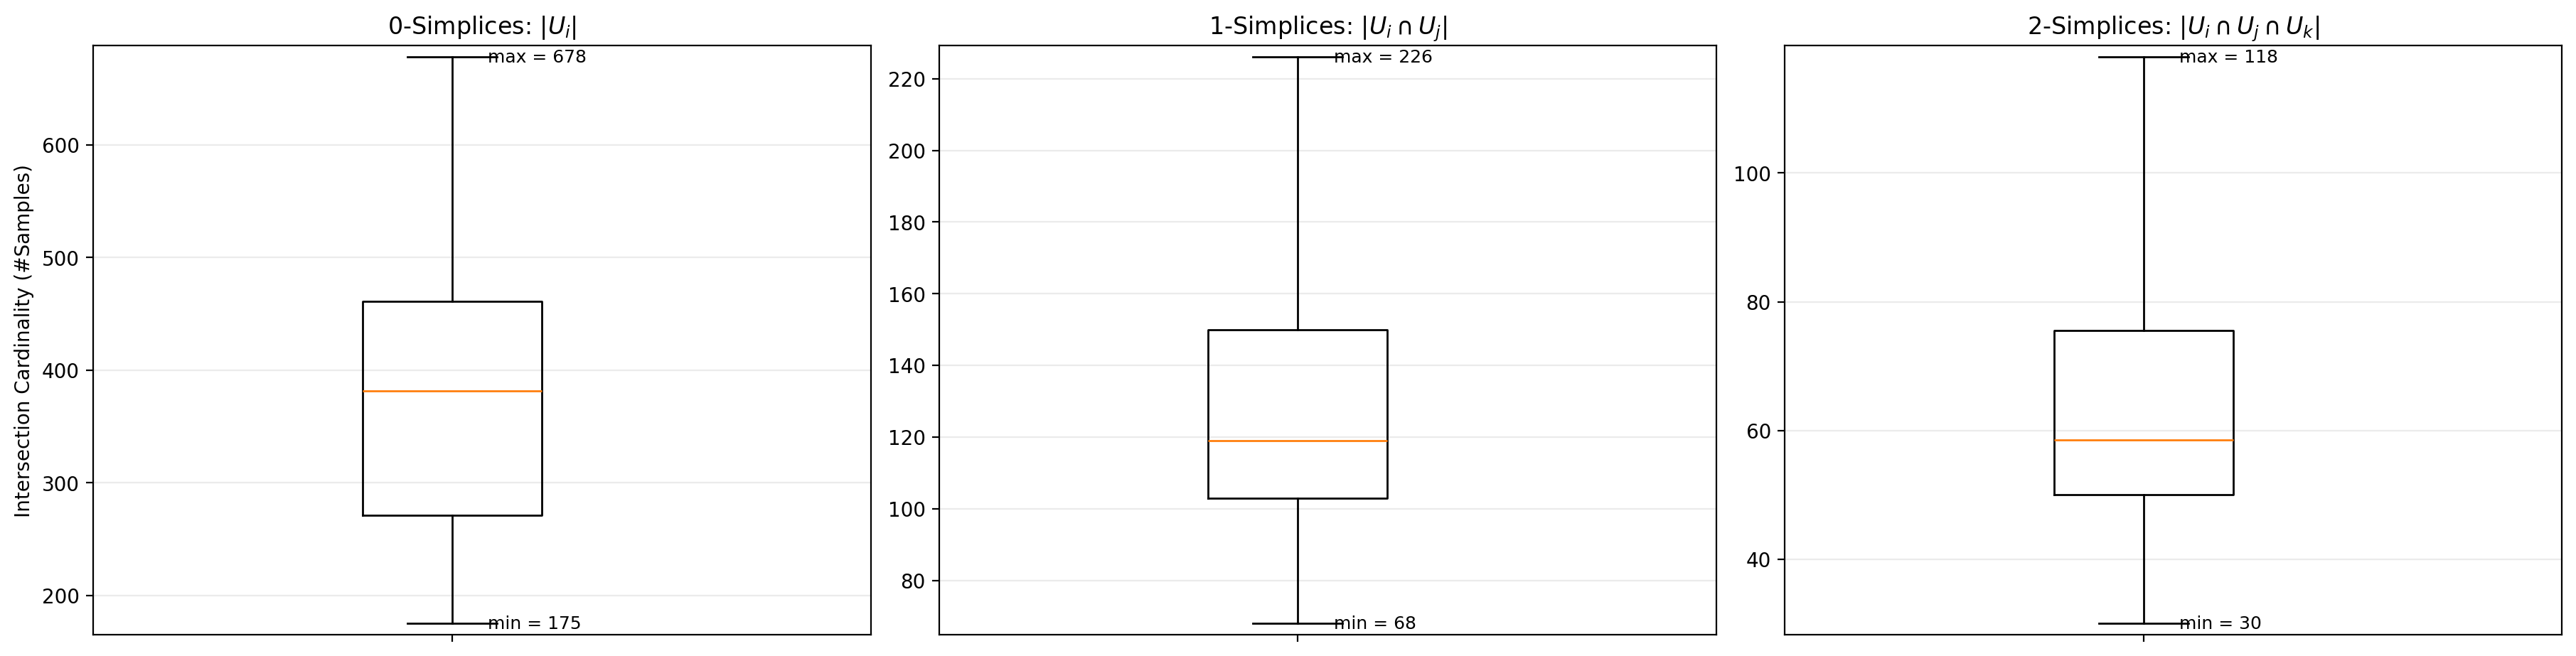

In [6]:
#Construct an open cover of RP2
n_landmarks = 40
rp2_cover = cb.make_rp2_fibonacci_star_cover(base_points, n_pairs = n_landmarks)

summ = rp2_cover.summarize(plot = True)

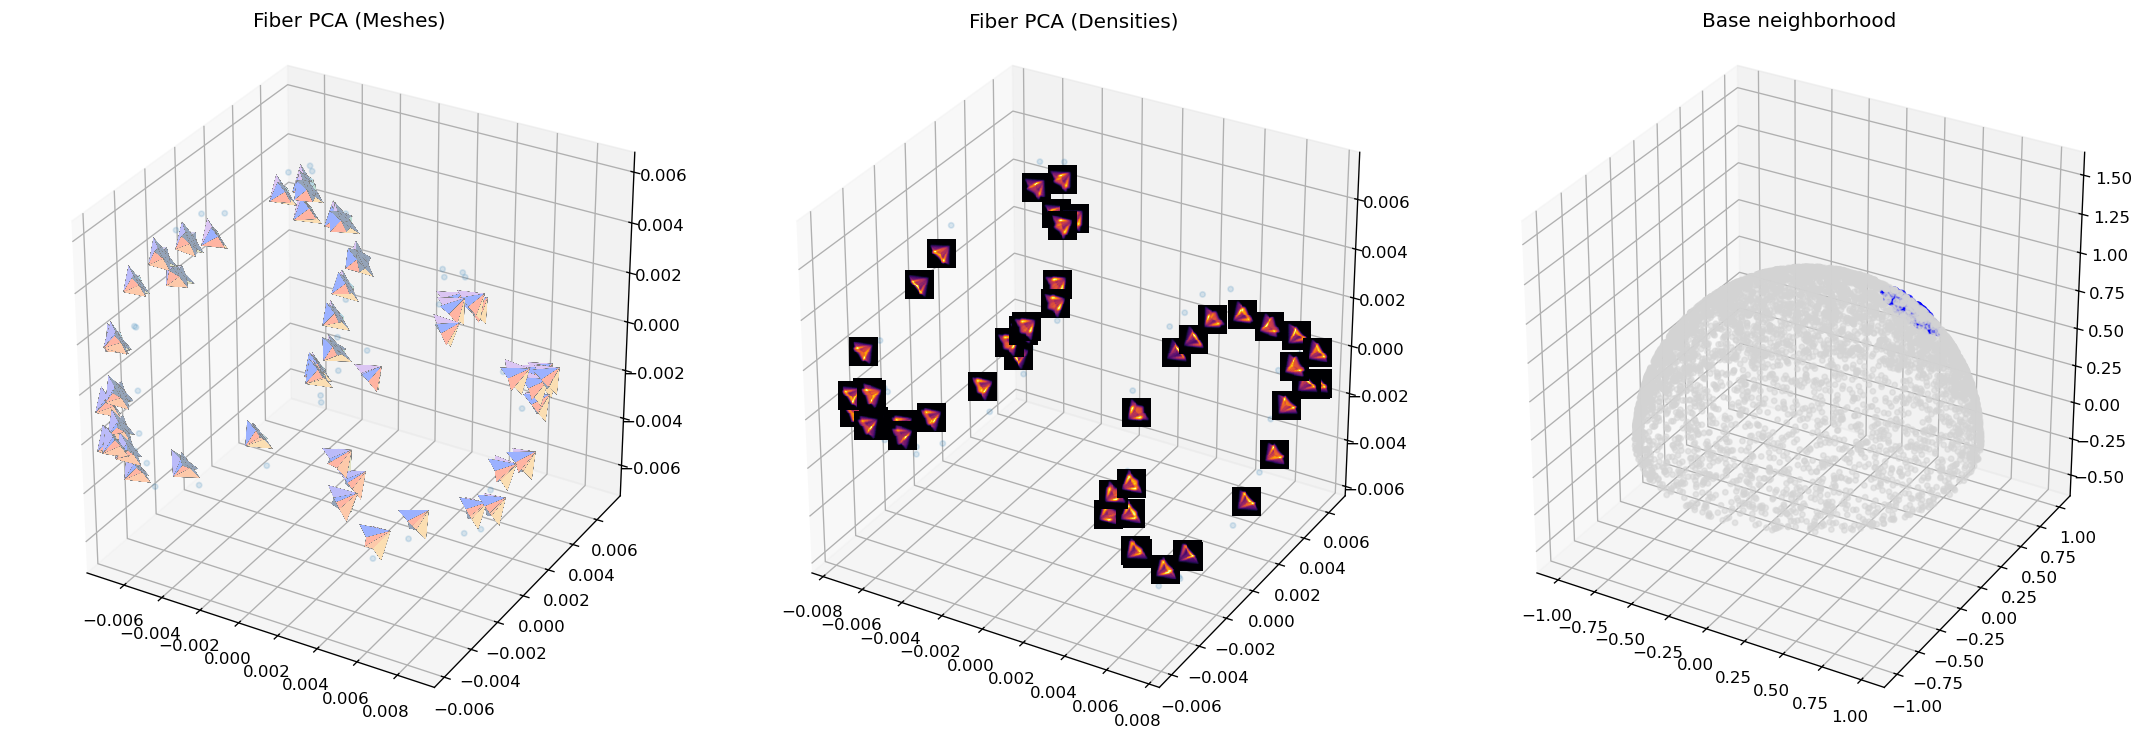

In [7]:
#Show a visualization of a 'fat fiber' of the projection map

center_ind = 579
r = 0.2
dist_mat = rp2_metric().pairwise(X=base_points)
nearby_indices = np.where(dist_mat[center_ind] < r)[0]

fiber_data = data[nearby_indices]
vis_data = mesh_data[nearby_indices]


fig = plt.figure(figsize=(18, 6), dpi=120)
ax1 = fig.add_subplot(1, 3, 1, projection="3d")
ax2 = fig.add_subplot(1, 3, 2, projection="3d")
ax3 = fig.add_subplot(1, 3, 3, projection="3d")

# PCA labeled with meshes
cb.fiber_vis(
    fiber_data,
    mesh_vis,
    vis_data=vis_data,
    max_images=50,
    zoom=0.08,
    ax=ax1,
    show=False,
)
ax1.set_title("Fiber PCA (Meshes)")

# PCA labeled with density projections
cb.fiber_vis(
    fiber_data,
    vis_func=vis_func,
    max_images=50,
    zoom=0.05,
    ax=ax2,
    show=False,
)
ax2.set_title("Fiber PCA (Densities)")

# Base visualization
cb.base_vis(
    base_points,
    center_ind,
    r,
    dist_mat,
    use_pca=False,
    ax=ax3,
    show=False,
)
ax3.set_title("Base neighborhood")

plt.tight_layout()
plt.show()


## Fiberwise Clustering 

In [ ]:
#Run persistence on fibers to get an epsilon value for fiberwise clustering
fiber_ids, dense_idx_list, rips_list = cb.get_local_rips(
    data,
    rp2_cover.U,
    p_values=None,
    to_view = [0,17,29],
    maxdim=1,
    n_perm=500,
    random_state=None,
)

fig, axes = cb.plot_local_rips(
    fiber_ids,
    rips_list,
    n_cols=3,
    titles='default',
    font_size=20,
)

Running fiberwise clustering on the dataset...



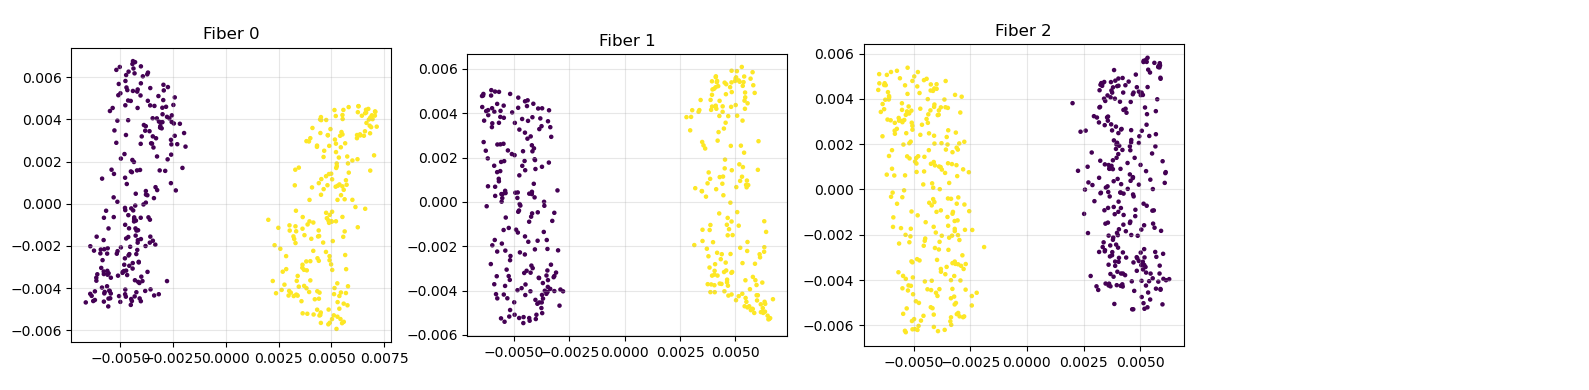

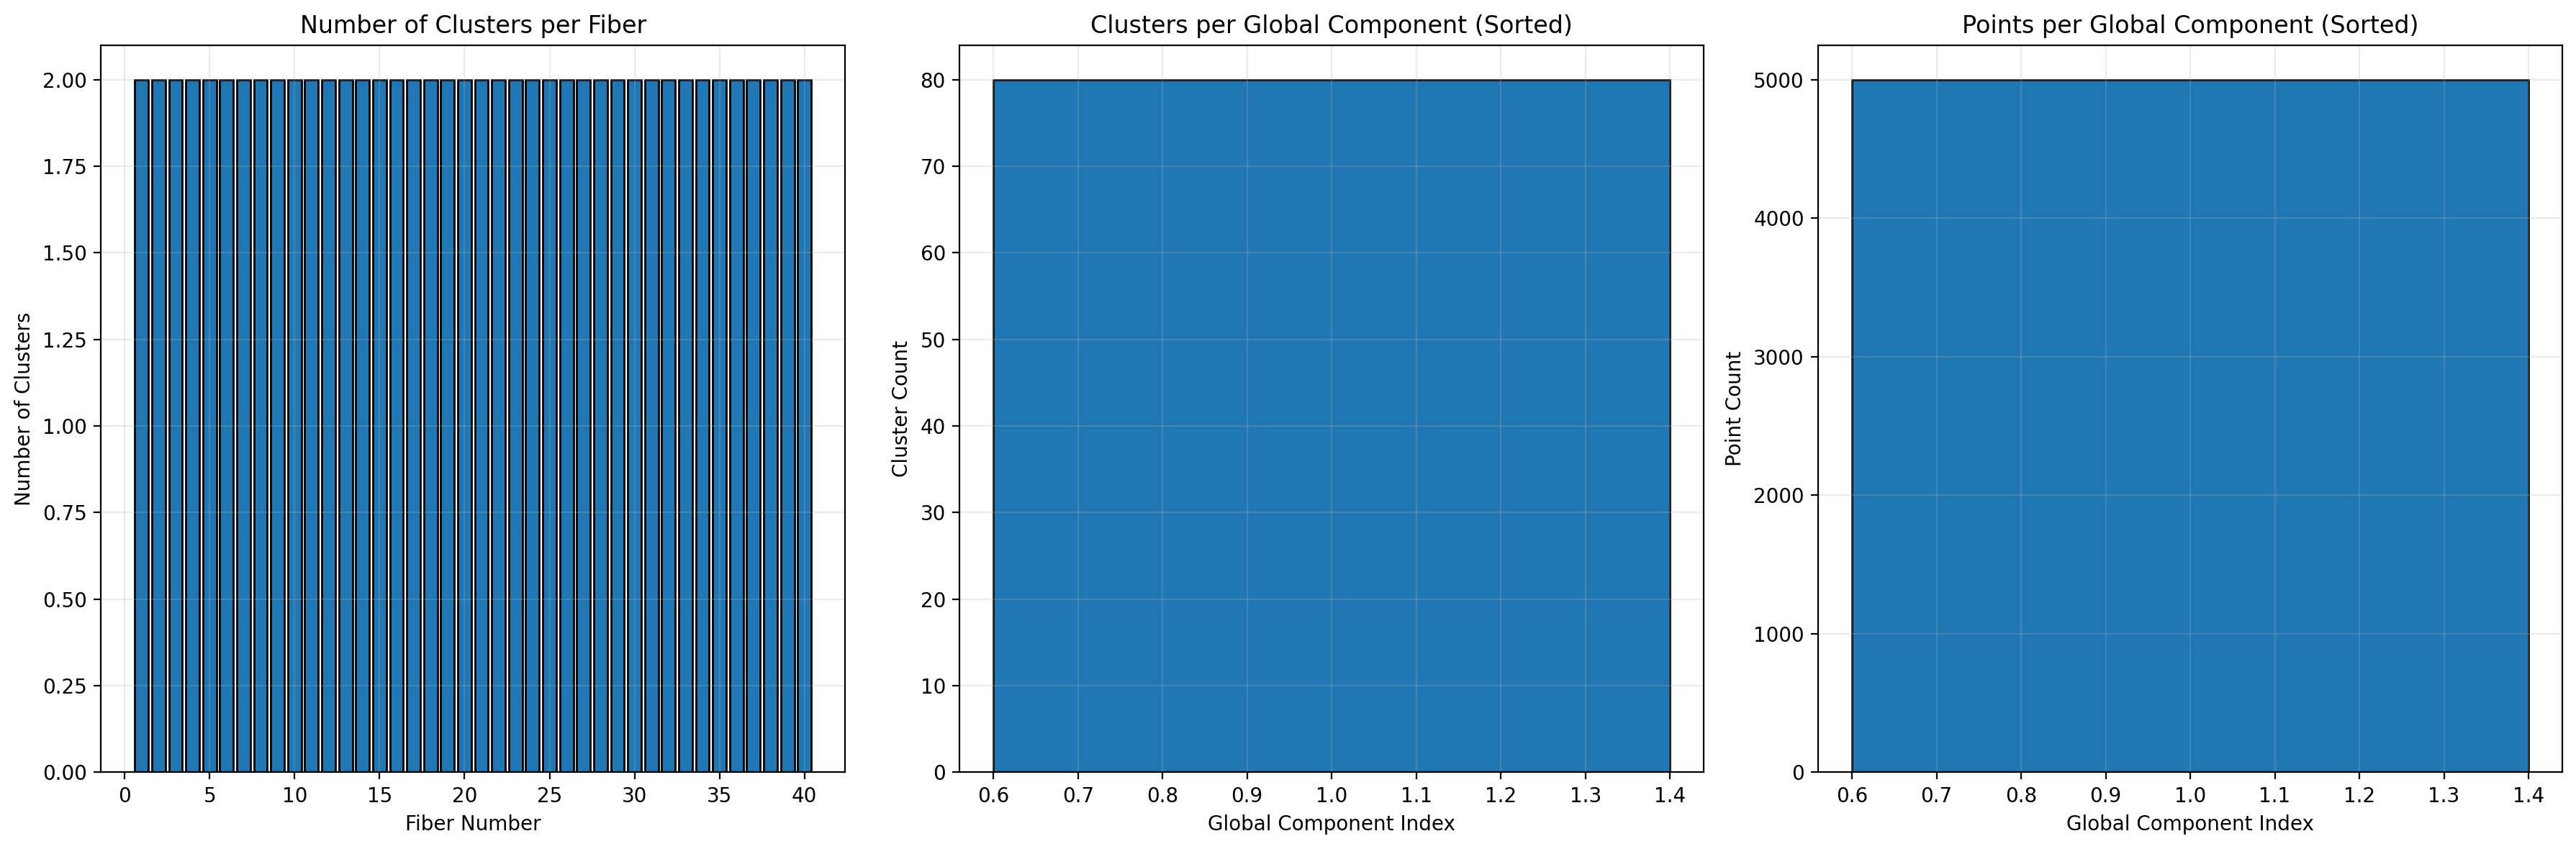

In [8]:
#Run fiberwise clustering to separate each fiber into two components

eps_values = 0.0125*np.ones(len(rp2_cover.U))
min_sample_values = 5*np.ones(len(rp2_cover.U))

print('Running fiberwise clustering on the dataset...')
print('')
components, G, graph_dict, cl, summary = cb.fiberwise_clustering(data, 
                                                              rp2_cover.U, 
                                                              eps_values, 
                                                              min_sample_values)

to_view = [0,1,2]
fig,ax = cb.plot_fiberwise_pca_grid(summary, to_view = to_view)
plt.show()
fig, ax = cb.plot_fiberwise_summary_bars(summary, hide_biggest=False)
plt.show()

In [9]:
#Confirm that the Sigma_2 monodromy is non-trivial (i.e., the whole dataset is one connected component)
signs = cb.get_cocycle_dict(G)

is_a_coboundary = cb.solve_Z2_edge_coboundary(rp2_cover.nerve_edges(), signs, len(rp2_cover.U))[0]

print(f'Is a coboundary: {is_a_coboundary}')

Is a coboundary: False


## Cluster Visualization 

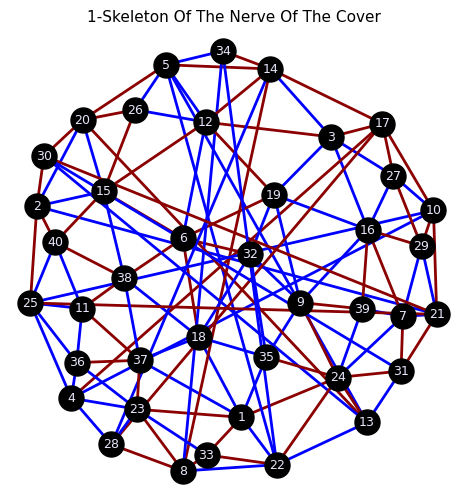

In [11]:
#Show the 1-skeleton of the nerve of the cover labeled by the permutation cocycle
signs_O1 = {edge:(-1) ** signs[edge] for edge in signs.keys()}

dist_mat = rp2_metric().pairwise(X = rp2_cover.landmarks, Y = rp2_cover.base_points)

node_labels = [f"{i+1}" for i in range(rp2_cover.landmarks.shape[0])]

fig, axes = cb.nerve_vis(
    rp2_cover,
    cochains={1:signs_O1},
    base_colors={0:'black', 1:'black', 2:'pink'},
    cochain_cmaps={1:{1: 'blue', -1:'darkred'}},
    opacity=0,
    node_size=18,
    line_width=2,
    node_labels=node_labels,
    fontsize=9,
    font_color='lavender',
    title='1-Skeleton Of The Nerve Of The Cover'
)

plt.show()

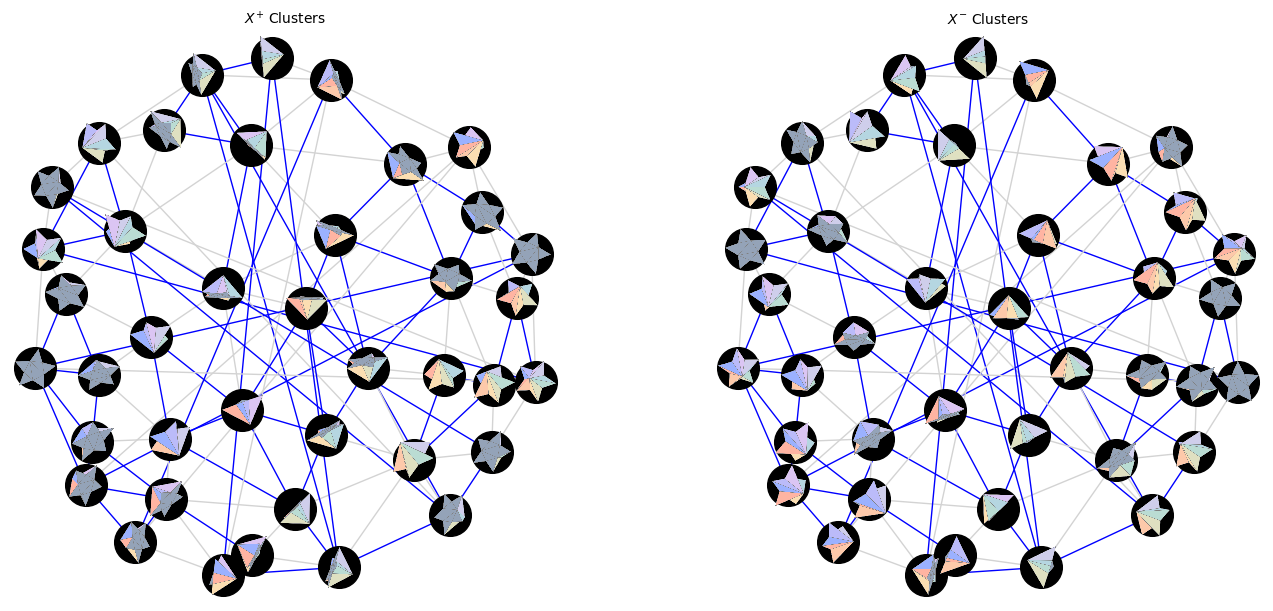

In [18]:
# Show the nodes of G labeled with + and - side by side

fig, axes = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)

for ax, g in zip(axes, [0, 1]):

    sample_inds = []

    # Choose a representative for each cluster with label g
    for node in G.nodes():
        (j, k) = node
        if k == g:
            node_inds = cl[j] == k
            min_idx_local = np.argmin(dist_mat[j, node_inds])
            min_index = np.where(node_inds)[0][min_idx_local]
            sample_inds.append(min_index)

    sample_inds = np.array(sample_inds, dtype=int)

    sample_mesh_data = mesh_data[sample_inds]
    sign = "+" if g == 0 else "-"
    cb.nerve_vis(
        rp2_cover,
        cochains={1: signs_O1},
        base_colors={0: "black", 1: "black", 2: "pink"},
        cochain_cmaps={1: {1: "blue", -1: "lightgray"}},
        node_size=30,
        line_width=1,
        node_labels=None,
        fontsize=8,
        font_color="white",
        vis_func=mesh_vis,
        data=sample_mesh_data,
        image_zoom=0.105,
        title = rf"$X^{{{sign}}}$ Clusters",
        ax=ax,                
        show=False,           
    )

plt.show()


## Lift To A Bundle Over $\mathbb{S}^{2}$ 

### Cover And Nerve Summary
- $n_\text{sets} = 80$, $n_\text{samples} = 5000$

**Recorded Simplex Counts:**

- $\#(\text{0-simplices}) = 80$
- $\#(\text{1-simplices}) = 234$
- $\#(\text{2-simplices}) = 156$
- *No recorded simplices in dimensions* $\ge 3$

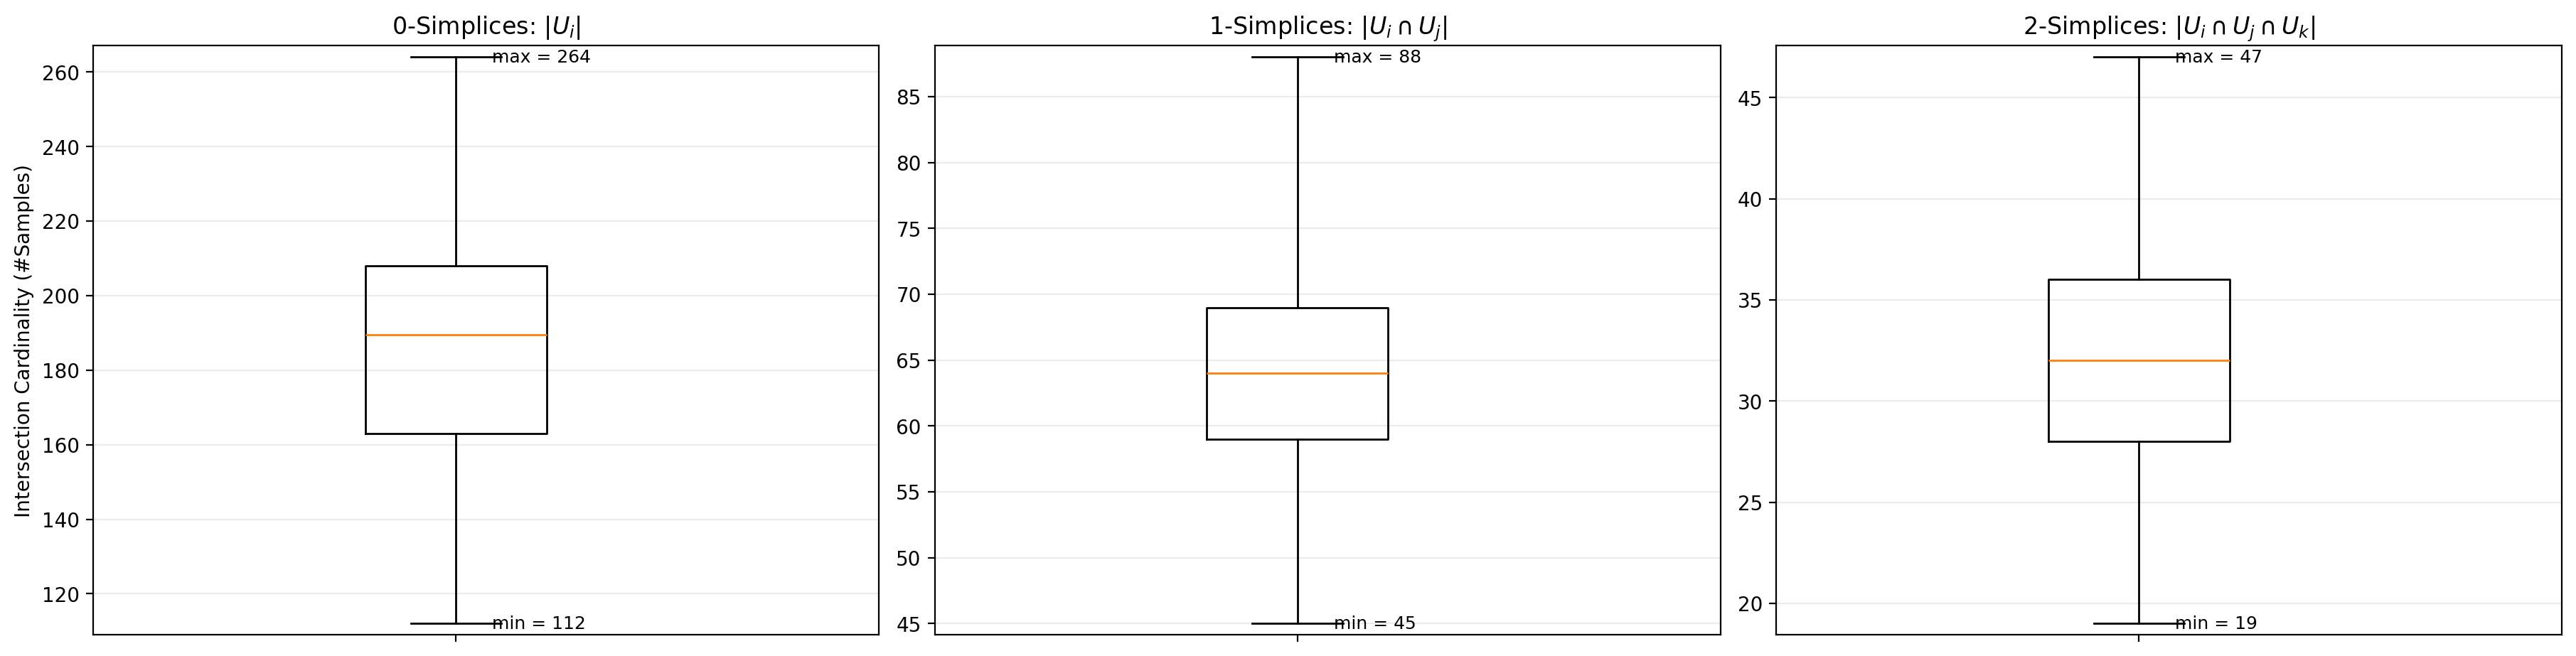

Cover constructed.


In [22]:
#Construct a lift of the base map from RP2 to S2
lifted_base_points = cb.lift_base_points(G, cl, base_points)

n_landmarks = 80
s2_cover = cb.make_s2_fibonacci_star_cover(lifted_base_points, n_vertices = n_landmarks)
summ = cover.summarize(plot = True)

print('Cover constructed.')

In [25]:
#Compute local trivializations and characteristic classes
s2_bundle = cb.build_bundle(
    data,
    s2_cover,
    CircularCoords_cls=CircularCoords,      #optionally use sparse cc's
    landmarks_per_patch = 500,
    show=True
)


<IPython.core.display.Math object>

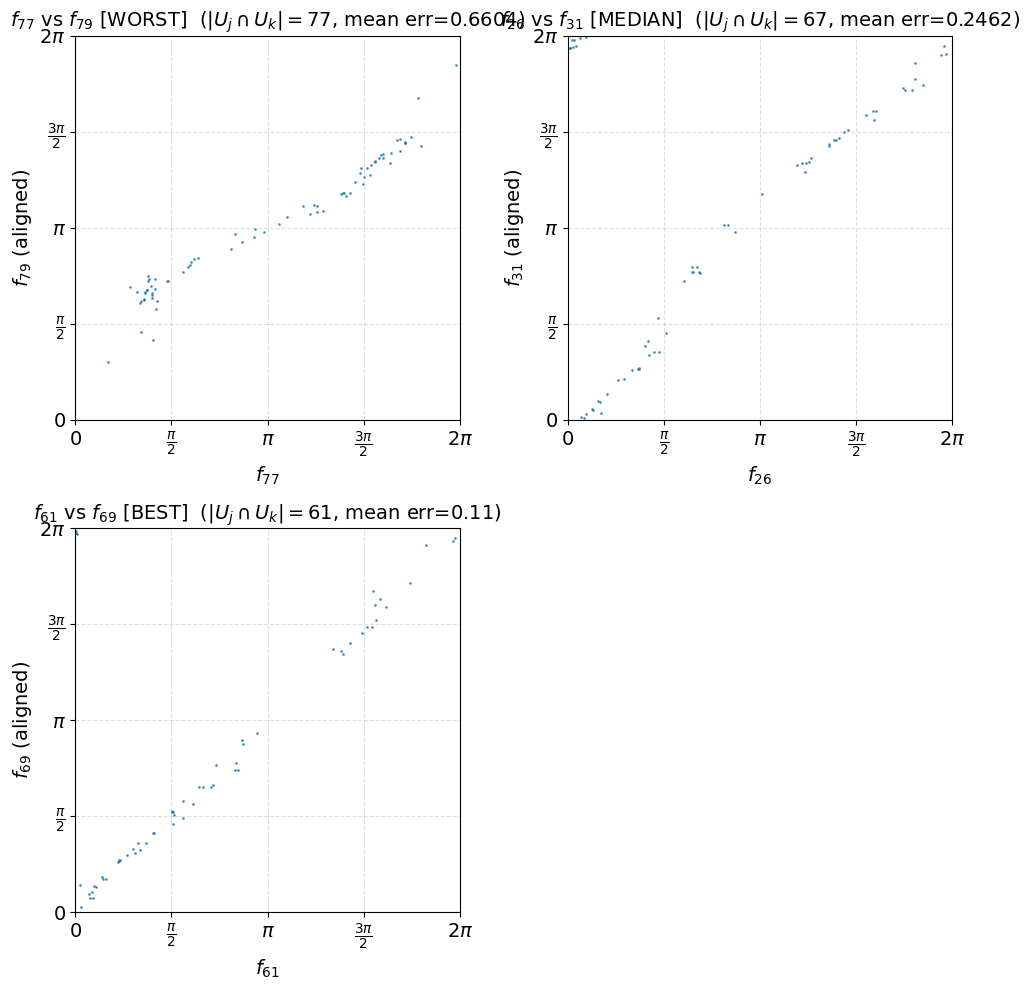

In [28]:
fig = s2_bundle.compare_trivs(align = True)
plt.show()

In [29]:
#Compute class persistence on the weights filtration of the nerve
pers = s2_bundle.get_persistence(show = True)


<IPython.core.display.Math object>

In [30]:
#Compute a global coordinatization map compatible with the maximal subcomplex
#on which the characteristic class representatives are coboundaries
s2_triv_result = s2_bundle.get_global_trivialization()
print('Global coordinates computed.')

Global coordinates computed.


In [49]:
#Show a visualization of the 2-skeleton of the nerve
fig = s2_bundle.show_max_trivial()
plt.show()

# Restriction To An Equator

In [32]:
#Get patches whose projection lie near the equator in RP2
eps = 0.15
eq_inds = np.abs(base_points[:,-1]) < eps
eq_data = s2_bundle.data[eq_inds]
eq_base_angles = np.arctan2(s2_cover.base_points[eq_inds,1], s2_cover.base_points[eq_inds,0]) % (2*np.pi)


In [36]:
#Construct a new bundle along the equator in RP2

#Set up an open cover of the base circle
n_landmarks = 12
landmarks = np.linspace(0, 2*np.pi, n_landmarks, endpoint= False)
overlap = 1.99
radius = overlap* np.pi/n_landmarks

from circle_bundles.metrics import S1AngleMetric as s1_metric

eq_cover = cb.MetricBallCover(eq_base_angles, landmarks, radius, metric = s1_metric())
eq_cover_data = eq_cover.build()

#Construct local circular coordinates and model transitions as O(2) matrices
eq_bundle = cb.build_bundle(
    eq_data,
    eq_cover,
    CircularCoords_cls=CircularCoords,      #optionally use sparse cc's
    show=True,
)

#Get mesh data for visualization
eq_mesh_data = mesh_data[eq_inds]


<IPython.core.display.Math object>

In [37]:
#Compute global coordinates on equator data using a filtration of the nerve
eq_triv_result = eq_bundle.get_global_trivialization()
print('Global coordinates computed.')

Global coordinates computed.


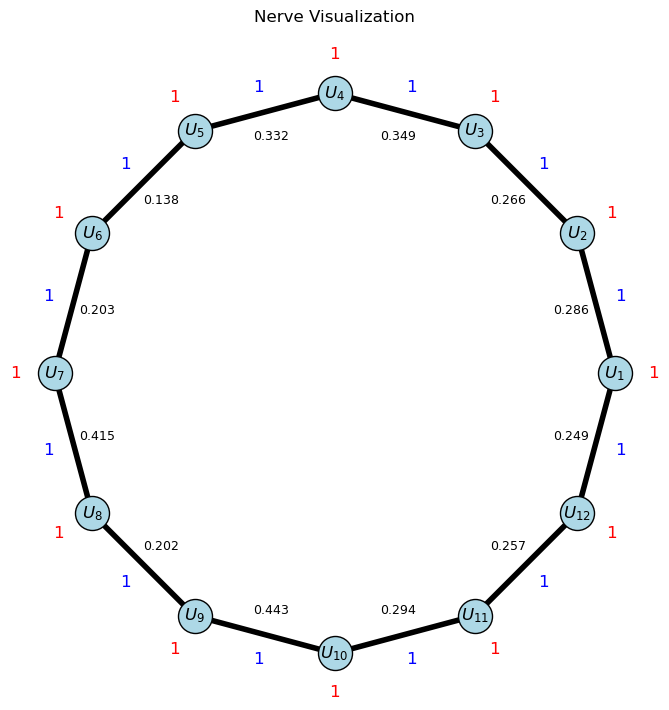

In [38]:
#Show a visualization of the restricted nerve

#Compute a potential for the restricted orientation class
eq_subcomplex = eq_bundle.get_max_trivial_subcomplex()
edges = eq_subcomplex.kept_edges
Omega = eq_bundle.classes.cocycle_used.restrict(edges)
phi_vec = Omega.orient_if_possible(edges)[2]
phi = {lmk: phi_vec[lmk] for lmk in range(n_landmarks)}
omega = eq_bundle.classes.omega_O1_used

fig = eq_bundle.show_circle_nerve(omega = omega, phi = phi)
plt.show()




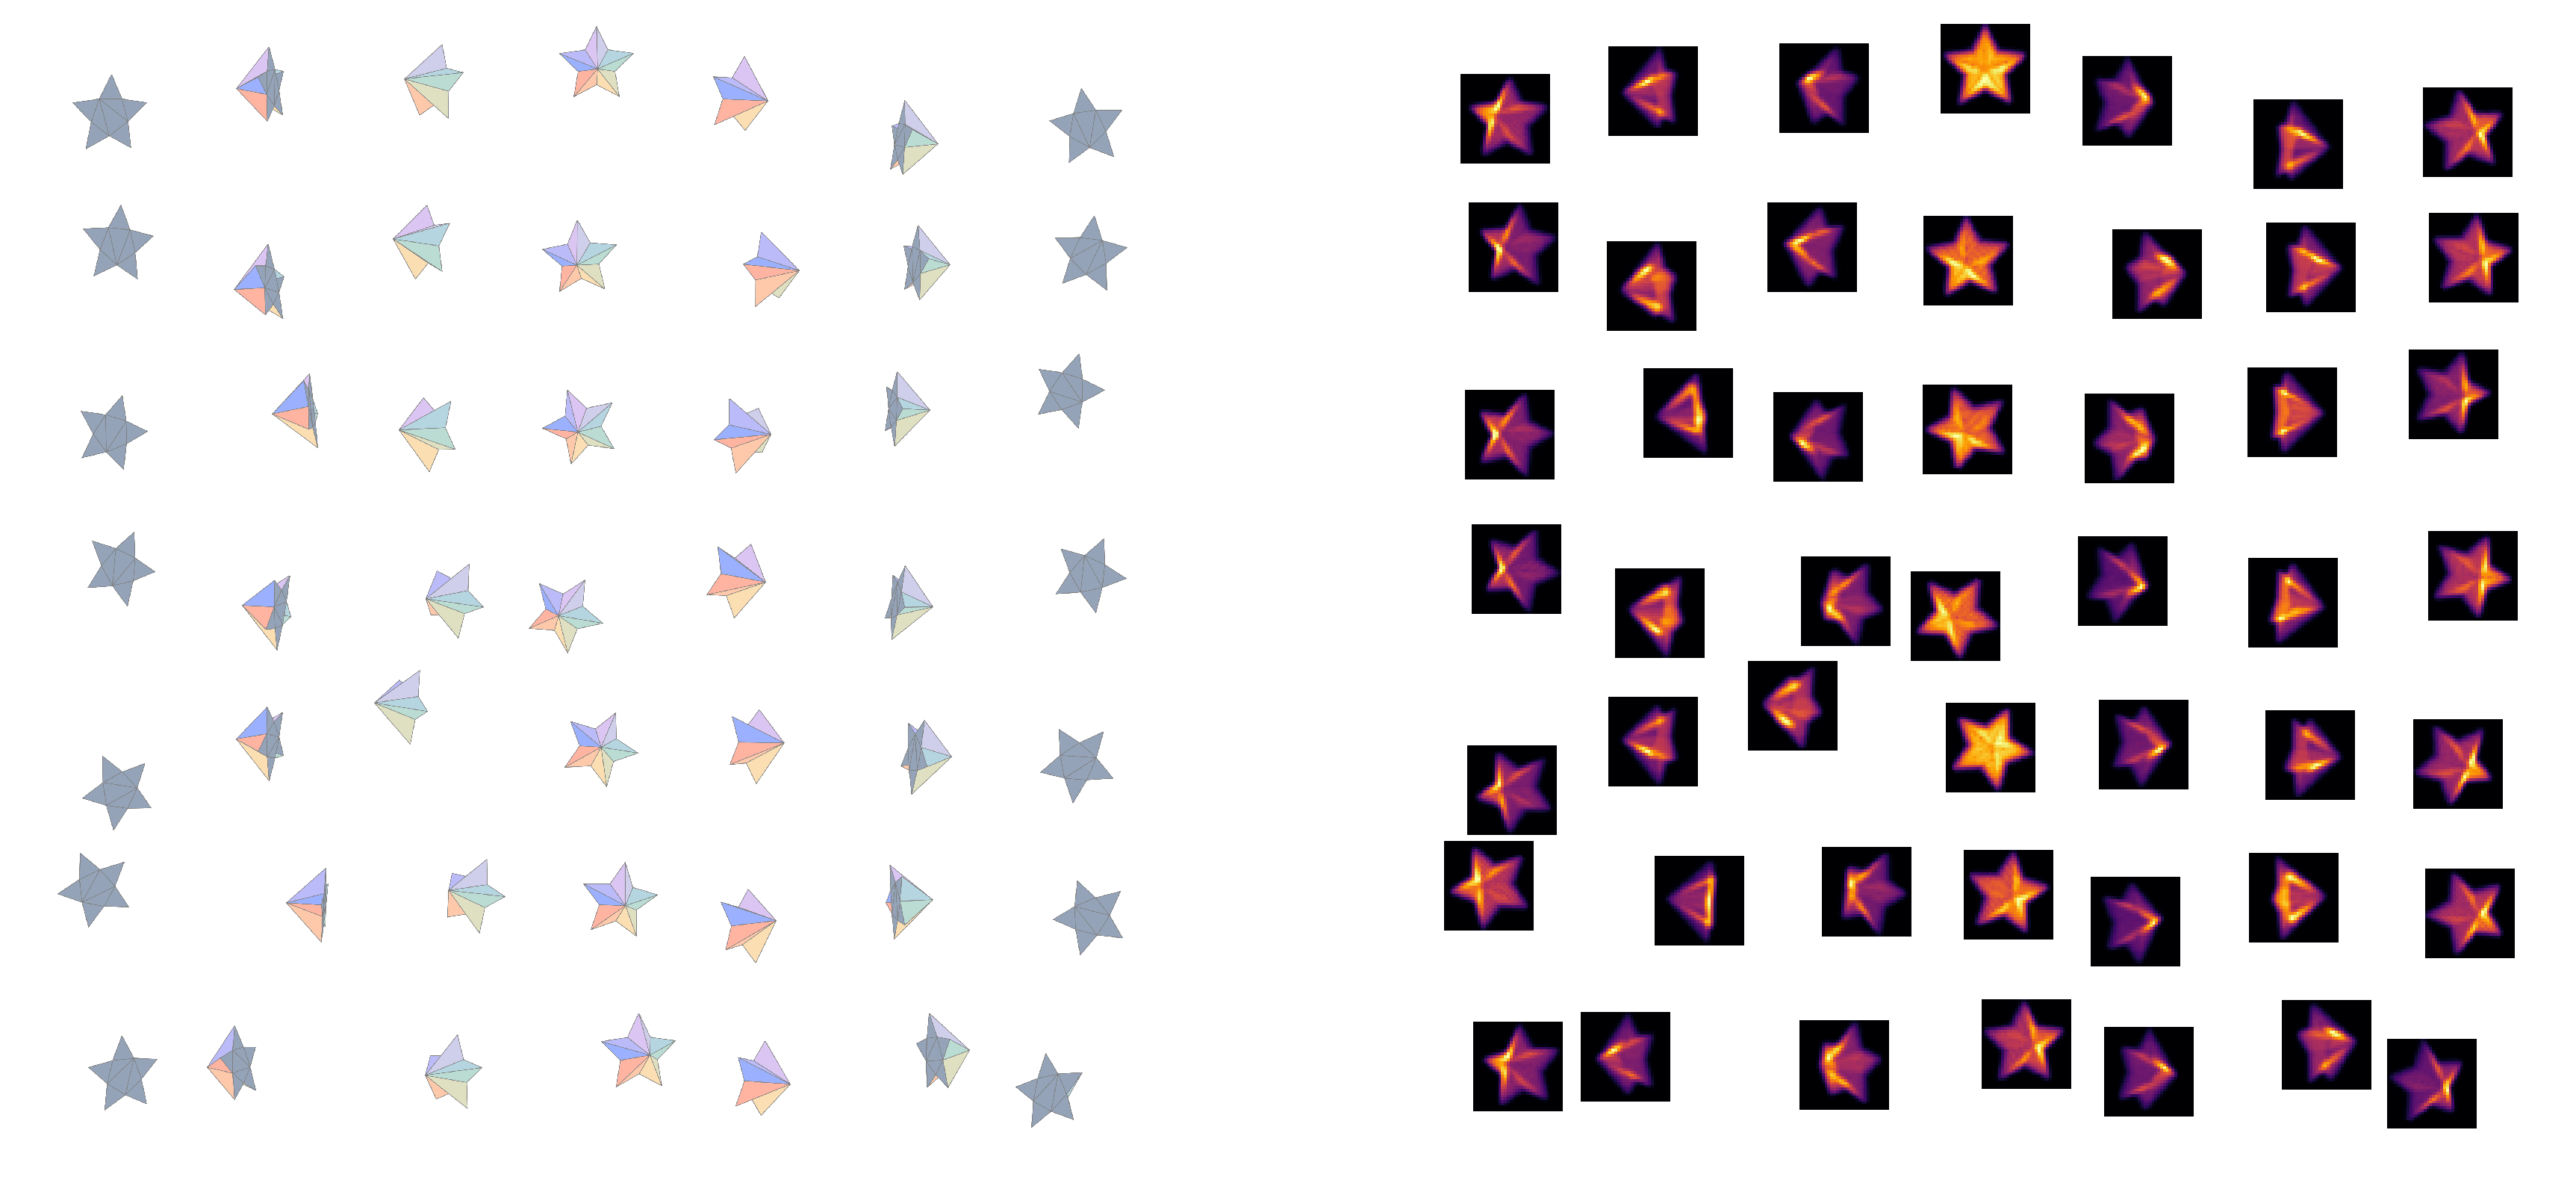

In [40]:
#Get a visualization of the data arranged by assigned coordinates using meshes
coords = np.array([eq_base_angles, eq_triv_result.F]).T
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 10), dpi=200)

fig = cb.lattice_vis(
    eq_mesh_data,
    coords,
    mesh_vis, 
    per_row=7,          
    per_col=7,          
    figsize=10, 
    thumb_px=100,
    dpi=200,
    ax = ax1,
)

#Get a visualization of the data arranged by assigned coordinates using meshes
fig = cb.lattice_vis(
    eq_data,
    coords,
    vis_func, 
    per_row=7,          
    per_col=7,          
    figsize=11, 
    thumb_px=120,
    dpi=200,
    ax = ax2,
)
plt.show()
